In [104]:
import numpy as np 
from scipy.stats import multivariate_normal
import itertools

# The class which defines the graph, transitions, and solver

In [105]:
# class graph_mdp():

#     def __init__(self,n_states,n_actions,rewards,init_state,init_P,init_v):
#         self.n_states = n_states                
#         self.n_actions = n_actions
#         self.r = rewards 
#         self.state = init_state
#         self.P = init_P
#         self.Q = init_Q
        
#     def transition_probs(self,action):
        
#         # get the post-interv. essential graphs
#         post_int_graphs = post_intervention_graphs(action)
        
#         # calculate the BIC for each one 
#         bic_scores = graphBIC(post_int_graphs)
        
#         # transform BIC scores to probabilities
#         self.P = ... 
        
#     def post_intervention_graphs(action):
#         """
#             Given current graph (self.state) 
#             and intervention on that graph (action)
#             return the set of post intervention
#             graphs (next states)
#         """
        
#         # 
        
#         return graphs
    
#     def normal_LL(x,y,beta,sigma):
#         mu = beta.dot(x.T)
#         ll = norm(loc=mu, scale=sigma).logpdf(y).sum()
#         return ll
                
    
#     def graphBIC(self,post_int_graphs):
        
#         def gBIC(g):
            
        
#         # calculate BIC score for every graph 
#         bic_scores=[]
#         for g in post_int_graphs:
#             bic_scores.append()
            
        
#         return bic_scores
    
#     def solve(self):
#         """
#             Given a max number of experiments
#             return the optimal policy which is 
#             the sequence of experiment on 
#             how to go from observed data to the 
#             causal graph
#         """
                
        
#         return causal_graph


    

## Below this cell is an experimentation section. Go to the last cell to run the experiment.

In [106]:
# example of adjacency matrix for 3 variables: x1, x2, x3


adj_matrices = {
    
    # A1 describes a graph where the edges are x1 -> x2 -> x3 
    "A1" : [[0,0,0],
            [1,0,0],
            [0,1,0]],

    # A2 describes a graph where the edges are x2 -> x1 -> x3 
    "A2" : [[0,1,0],
            [0,0,0],
            [1,0,0]],

    # A3 : x3,x2 -> x1
    "A3" : [[0,1,1],
            [0,0,0],
            [0,0,0]],

    # A4 : x2, x1, x3 (independent)
    "A4": [[0,0,0],
            [0,0,0],
            [0,0,0]],


    # A5 : x1 -> x2, x1,x2 -> x3
    "A5" : [[0,0,0],
            [1,0,0],
            [1,1,0]],

    # AC describes a fully connected, undirected graph (not causal)
#     "AC": [[0,1,1],
#             [1,0,1],
#             [1,1,0]]
}

In [107]:
def generate_dataset(N,true_g,sigma):
    
    if true_g == "A1":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x2 + np.random.normal(loc=0,scale=sigma,size=N)
        
    elif true_g == "A2":
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x1 = x2 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
      
    elif true_g == "A3":
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x3 = np.random.normal(loc=0,scale=sigma,size=N)        
        x1 = x2 + x3 + np.random.normal(loc=0,scale=sigma,size=N)
    
    elif true_g == "A4":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x3 = np.random.normal(loc=0,scale=sigma,size=N)
        
    elif true_g == "A5":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x1 + x2 + np.random.normal(loc=0,scale=sigma,size=N)
    else:
        print(f"Graph {true_g} not found.")
        
    x = np.c_[x1,x2,x3]
    y = x.T
    return x,y


## Sample from an interventional distribution


In [108]:
import numpy.ma as ma

def sample_interv_dist(n_samples, interv_node, coeff_matrix):
    # sample from the interventional distribution of a true graph
    # for simplicity, assume only one node is intervened on
    n_nodes = coeff_matrix.shape[1]
    X = np.full((n_samples, n_nodes), np.inf)
    # want to do this in such a way that nodes are assigned values in the right order
    # assign interventional node first
    X[:, interv_node] = np.random.normal(loc = 0, scale = 1, size = n_samples) # just random interventions for now; could actually fix concrete values later
    # dumb thing that might actually work
    # keep redoing matrix multiplications until there are no nan entries
    assigned_nodes = np.full(n_nodes, False) # keep track of which nodes have been assigned
    assigned_nodes[interv_node] = True
    while np.sum(assigned_nodes) < n_nodes:
        for node in range(n_nodes):   
            if node == interv_node:
                continue
            # if coeff matrix is just zero, assign noise and move on
            # print(coeff_matrix[:, node], node, X)
            if (coeff_matrix[:, node] == 0).all():
                X[:, node] = np.random.normal(loc = 0, scale = 1, size = n_samples)
            else:
                # use coeffs to mask the matrix
                coeff_mask = coeff_matrix[:, node] != 0
                X_masked = X[:, coeff_mask]
                coeff_masked = coeff_matrix[:, node][coeff_mask]
                res = X_masked @ coeff_masked + np.random.normal(loc = 0, scale = 1, size = n_samples)
                if np.sum(np.isnan(res)) != 0 or np.sum(np.isinf(res)) != 0:
                    continue
                else:
                    X[:, node] = res
            assigned_nodes[node] = 1
        # print(X)
    return X, X.T

# test it
interv_node = 1
coeff_matrix = np.array([[0, 1, 1], [0, 0, 2], [0, 0, 0]])
X, y = sample_interv_dist(5, interv_node, coeff_matrix)
print(X, y)

[[-0.51971501  0.52582642  1.38692413]
 [-1.13239522 -0.56948713 -2.39993404]
 [-1.44179208 -0.15292385 -0.57611704]
 [ 0.05718901 -0.3722285  -1.17258099]
 [ 0.58921046 -0.29199058  0.42808413]] [[-0.51971501 -1.13239522 -1.44179208  0.05718901  0.58921046]
 [ 0.52582642 -0.56948713 -0.15292385 -0.3722285  -0.29199058]
 [ 1.38692413 -2.39993404 -0.57611704 -1.17258099  0.42808413]]


In [109]:
def log_lik(beta, y, x):

    mu = beta.dot(x.T)
    neg_llik = -1*norm(loc=mu, scale=1).logpdf(y).sum()

    return neg_llik

## Defining the MDP

In [110]:
from scipy.special import softmax
from scipy import optimize
from scipy.stats import norm

# Gym-like wrapper
class LabeledMDP():
    def __init__(self, true_graph_name, true_coeffs, max_time = 200):
        self.true_graph = np.asarray(adj_matrices[true_graph_name])
        self.true_coeffs = true_coeffs
        self.true_graph_name = true_graph_name
        self.n_nodes = np.asarray(self.true_graph).shape[0]
        self.max_time = max_time

        # state space
        self.curr_graph = self.get_reset_graph()
        self.t = 0 # keep track of the timestep
        self.n_experiments = 0 # experiments run so far
        self.intervened_nodes = {} # keep track of which nodes have been intervened on
        self.obs_dim = np.prod(self.curr_graph.shape) + 2

        # action space
        # for each node, there are experiments with three different choices n: {10, 100, 1000}
        self.experiment_sizes = [5, 20]
        self.experiment_actions = np.array(list(itertools.product(np.arange(self.n_nodes), self.experiment_sizes)))
        self.n_actions = len(self.experiment_actions) + 1 # add one for the stop action

    def get_reset_graph(self):
        return np.ones((self.n_nodes, self.n_nodes)) # the totally connected graph

    def reset(self):
        self.t = 0
        self.curr_graph = self.get_reset_graph()
        self.intervened_nodes = {}
        self.n_experiments = 0
        return self.create_state()

    def create_state(self):
        frac = len(self.intervened_nodes.keys()) / self.n_nodes
        s = np.concatenate((np.array(self.curr_graph).flatten(), [self.n_experiments, frac]))
        assert s.ndim == 1, "Not 1D feature vector"
        return s

    def correct_edges_frac(self):
        # compare correct and incorrect edges
        # use for shaped reward if desired
        n_correct_edges = np.sum(self.curr_graph == self.true_graph)
        # print(n_correct_edges, self.curr_graph == self.true_graph)
        return n_correct_edges / np.prod(self.curr_graph.shape)

    def transition_graph(self, node, n_samples):
        # option: define candidate graphs the agent considers
        # for now, just set it to be all possible graphs
        # candidate_graphs = list(adj_matrices.keys())

        # another option: generate random graphs based on which nodes you intervene on
        n_candidates = 3
        n_edges_to_flip = min(3, self.n_nodes - 1) # make sure you aren't flipping more edges than are possible
        # given the current graph, permute edges that are connected to the current node
        # rows are oncoming edges, so the intervened node is the column
        candidate_graphs = []
        for _ in range(n_candidates):
            G = np.copy(self.curr_graph)

            # pick edges to randomly flip
            edges = np.random.choice(self.n_nodes, size = n_edges_to_flip, replace = False)
            
            # for each edge, give possibilities
            for edge in edges:
                # print(edge, node)
                possible_choices = [-1, 1, 0]
                possible_choices.remove(G[edge, node])
                G[edge, node] = np.random.choice(possible_choices)
    
            candidate_graphs.append(G)
        # also append the current graph
        candidate_graphs.append(self.curr_graph)


        # std dev of generated data
        sigma = 1.

        # placeholder
        # x,Y = generate_dataset(n_samples,self.true_graph_name,sigma)

        # interventional data
        x, Y = sample_interv_dist(n_samples, node, self.true_coeffs)
        # print(x, Y)

        ll=[]
        bic_scores = []
        # for g_name in candidate_graphs:
        for G in candidate_graphs:
            # G = np.array(adj_matrices[g_name])
            # print(G)
            graph_ll=0
            for var in range(self.n_nodes):
                data = Y[var]
                predictors = np.einsum('ij,ij->ij',np.tile(G[var],(n_samples,1)),x)
                opt_res = optimize.minimize(fun = log_lik, 
                                        x0 = [0, 0, 0], 
                                        args = (data, predictors))

                if opt_res['success'] == False:
                    print(f"Failed fit for model: {g_name} (true:{true_graph})")
                    graph_ll += -1e10
                           
                graph_ll += -1*opt_res['fun']
            ll.append(graph_ll)
            graph_complexity = G.sum()
            
            # Note: scipy minimize returns the negative log likelihood value
            bic_score = graph_ll - .5 * np.log(n_samples) * graph_complexity
            bic_scores.append(bic_score)

        # transition to graphs w/ probability proportional to BIC scores
        # option 1: softmax
        p = softmax(bic_scores)
        # print(p)
        next_ix = np.random.choice(len(candidate_graphs), p = p)
        return np.array(candidate_graphs[next_ix])


    def step(self, a):
        assert a >= 0, "action out of range"
        assert a < self.n_actions, "action out of range"
        done = False
        r = 0
        info = 0 # the unshaped reward
        if a == self.n_actions - 1:
            # STOP action
            done = True
            if (self.true_graph == self.curr_graph).all():
                r += 1
                info = 1
        else:
            # experiment action
            node, n_samples = self.experiment_actions[a]
            self.n_experiments += n_samples
            self.curr_graph = self.transition_graph(node, n_samples)
            r += self.correct_edges_frac() # shaped reward based on number of correct edges
            r -= n_samples / (10 * np.max(self.experiment_sizes))# penalty for size of experiment
        self.t += 1
        # if self.t >= self.max_time:
        #     done = True
        return self.create_state(), r, done, info


In [111]:
# sanity checks for MDP defined above
labeled_mdp = LabeledMDP(true_graph_name = "A1", true_coeffs = np.asarray(adj_matrices["A1"])) # just linear gaussian with 0, 1 coeffs
s = labeled_mdp.reset()
print(s)

sp, r, done, _ = labeled_mdp.step(1)
print(sp, r, done)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
[ 1.  1.  1. -1.  1.  1. -1.  1.  1. 20.  0.] 0.0111111111111111 False


## Defining a RL agent

In [112]:
# base agent
class BaseAgent():
    def __init__(self, env_params, agent_params, names_to_suppress=[]):
        self.env_params = env_params
        self.agent_params = agent_params 
        self.names_to_suppress = names_to_suppress
        self.name = self.generate_name()

        # RL stuff
        self.gamma = self.agent_params["gamma"]
        self.Q = np.zeros([env_params["n_actions"], env_params["obs_dim"]])

        if "eps" in self.agent_params:
            self.eps = self.agent_params["eps"]

    def set_env(self, env):
        self.env = env

    def generate_name(self):
        # generate agent full name from agent_params and base_name 
        params = ["{}={}".format(name, self.agent_params[name]) for name in self.agent_params if name not in self.names_to_suppress]
        return "{}_{}".format(self.base_name, '_'.join(params))

    def act(self, s):
        pass 

    def eps_greedy_act(self, s):
        if self.eval is False:
            eps = self.eps
        else:
            # act greedily if we're evaluating
            eps = 0

        if np.random.random() < eps:
            action = np.random.randint(self.env_params["n_actions"])
        else: 
            Qs = self.Q @ s
            assert np.isnan(Qs).sum() == 0
            action = np.random.choice(np.where(Qs == Qs.max())[0])
        return action
  
    # def get_eps(self):
    #     eps = self.eps_init * (1. - self.frame / self.eps_zero_by) + (self.eps_final) * self.frame / self.eps_zero_by
    #     eps = max(min(eps, self.eps_init), self.eps_final)
    #     return eps

    def step(self, s, a, r, sp, done):
        pass

    def run(self, env, eval = False):
        # for stats 
        self.returns = []
        self.unshaped_returns = []
        self.returns_and_frame_count = []
        self.frame = 0

        self.eval = eval

        # run it
        for episode in range(self.env_params["episodes"]):
            s = env.reset()
            G = 0
            unshaped_G = 0
            done = False
            self.curr_frame_count = 0
            while done is not True:
                a = self.act(s)
                sp, r, done, unshaped_r = env.step(a)
                # print(unshaped_r)

                G += (self.gamma ** self.curr_frame_count) * r # if we want to use the discounted return as the eval metric
                unshaped_G += (self.gamma ** self.curr_frame_count) * unshaped_r
                # G += r # if we want to use total reward as the eval metric

                # update agent if we're not evaluating
                if eval is False:
                    self.step(s, a, r, sp, done)

                self.curr_frame_count += 1
                if self.curr_frame_count >= self.env_params["max_frames_per_ep"]:
                    # NOTE: THIS NEEDS TO BE AFTER self.step() SO THAT WE BOOTSTRAP CORRECTLY
                    done = True

                # update state
                s = sp

                self.frame += 1    

            self.unshaped_returns.append(unshaped_G) 
            self.returns.append(G)
            self.returns_and_frame_count.append([G, self.curr_frame_count])
            
            # print("ep = {} | frame = {} | G = {} | ep length = {}".format(episode, self.frame - 1, unshaped_G, self.curr_frame_count))

# linear Q-learning
class QL(BaseAgent):
    def __init__(self, *args, **kwargs):
        self.base_name = "QL"
        super().__init__(*args, **kwargs)

    def act(self, s):
        return self.eps_greedy_act(s)

    def step(self, s, a, r, sp, done):
        self.Q[a, :] += self.agent_params["lr"] * (r + self.agent_params["gamma"] * (1. - done) * np.max(self.Q @ sp) - (self.Q @ s)[a]) * s

## Running a RL agent

In [117]:
training_set = ["A1", "A2", "A3"]
test_set = ["A4", "A5"]

env = LabeledMDP("A1", "A1")
obs_dim = env.obs_dim
n_actions = env.n_actions

# hyperparameters
H = 5
gamma = 1 - 1 / H
lr = 1e-3
eps = 0.1
agent_params = {"lr": lr, "eps": eps, "gamma": gamma}
runs = 30
env_params = {"episodes": 1, "max_frames_per_ep": 10, "n_actions": n_actions, "obs_dim": obs_dim}
n_training_epochs = 100

# agent
agent = QL(env_params, agent_params)

# results
train_res = []
test_res = []

# train the agent
for _ in range(n_training_epochs):
    if _ % 10 == 0:
        print(f"training epoch = {_ + 1} / {n_training_epochs}")

    # sample randomly from the training set
    train = training_set[np.random.choice(len(training_set))]

    # train
    env = LabeledMDP(train, np.array(adj_matrices[train]))
    agent.run(env)
    train_res.append(agent.returns)  
    print(f"avg return = {np.mean(agent.returns)}")

    # test the agent
    test_returns = []
    for test in test_set:
        # print(f"testing {test}")
        env = LabeledMDP(test, np.array(adj_matrices[test]))
        agent.run(env, eval = True)
        test_returns.append(agent.returns)
    test_res.append(np.mean(test_returns))
    # print(f"avg return = {np.mean(agent.returns)}")

train_res = np.array(train_res).squeeze()
test_res = np.array(test_res).squeeze()


training epoch = 1 / 100
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
training epoch = 11 / 100
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
training epoch = 21 / 100
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
training epoch = 31 / 100
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
training epoch = 41 / 100
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
avg return = 0.0
training epoch = 51 /

## Plot the data from the RL experiments

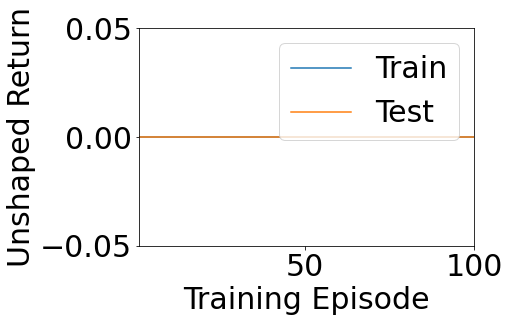

In [118]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
matplotlib.rcParams.update({'font.size': 30})

figsize = (15, 10)

# plot the training and test curves, cumulative avg
plt.plot(np.arange(n_training_epochs) + 1, np.cumsum(train_res) / (np.arange(n_training_epochs) + 1), label = "Train")
plt.plot(np.arange(n_training_epochs) + 1, np.cumsum(test_res) / (np.arange(n_training_epochs) + 1), label = "Test")
plt.xlabel("Training Episode")
plt.ylabel("Unshaped Return")
plt.legend()
plt.show()


## Understand what the RL agent is doing

## Run this cell to experiment with discovering the best graph based on BIC score

In [250]:
from scipy import optimize
from scipy.stats import norm

K=3
sigma = 1.0
candidate_graphs = ["A1","A2","A3","A4","A5"]
for i,true_graph in enumerate(candidate_graphs):    
    for n in range(5,30,5):
        x,Y = generate_dataset(n,true_graph,sigma)
        ll=[]
        bic_scores = []
        for g_name in candidate_graphs:
            G = np.array(adj_matrices[g_name])
            graph_ll=0
            for var in range(K):
                data = Y[var]
                predictors = np.einsum('ij,ij->ij',np.tile(G[var],(n,1)),x)
                opt_res = optimize.minimize(fun = log_lik, 
                                        x0 = [0, 0, 0], 
                                        args = (data, predictors))

                if opt_res['success'] == False:
                    #print(f"Failed fit for model: {g_name} (true:{true_graph})")
                    graph_ll += -1e10
                           
                graph_ll += -1*opt_res['fun']
            ll.append(graph_ll)
            graph_complexity = G.sum()
            
            # Note: scipy minimize returns the negative log likelihood value
            bic_score = graph_ll - .5*np.log(N)*graph_complexity
            bic_scores.append(bic_score)                    

        best_graph_ind = np.argmax(bic_scores)
        print(f"For N={n}, the best graph/BIC: {candidate_graphs[best_graph_ind]}/{np.round(bic_scores[best_graph_ind],2)}, true graph: {true_graph}/{np.round(bic_scores[i],2)}")

For N=5, the best graph/BIC: A1/-20.62, true graph: A1/-20.62
For N=10, the best graph/BIC: A1/-41.33, true graph: A1/-41.33
For N=15, the best graph/BIC: A1/-62.17, true graph: A1/-62.17
For N=20, the best graph/BIC: A1/-92.31, true graph: A1/-92.31
For N=25, the best graph/BIC: A1/-112.32, true graph: A1/-112.32
For N=5, the best graph/BIC: A2/-25.82, true graph: A2/-25.82
For N=10, the best graph/BIC: A2/-43.79, true graph: A2/-43.79
For N=15, the best graph/BIC: A2/-64.29, true graph: A2/-64.29
For N=20, the best graph/BIC: A2/-82.21, true graph: A2/-82.21
For N=25, the best graph/BIC: A2/-113.44, true graph: A2/-113.44
For N=5, the best graph/BIC: A2/-22.9, true graph: A3/-22.99
For N=10, the best graph/BIC: A3/-47.02, true graph: A3/-47.02
For N=15, the best graph/BIC: A3/-68.84, true graph: A3/-68.84
For N=20, the best graph/BIC: A3/-90.13, true graph: A3/-90.13
For N=25, the best graph/BIC: A3/-120.81, true graph: A3/-120.81
For N=5, the best graph/BIC: A4/-21.4, true graph: A4